In [89]:
import numpy as np
import matplotlib.pyplot as plt

# Задание 1

Решить линейную регрессию — найти прямую, которая описывает зависимость

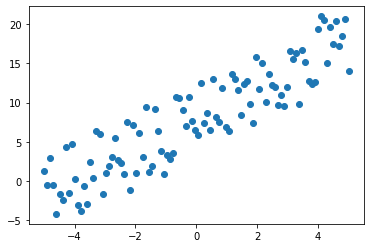

In [90]:
def generateAxes(minValue, maxValue):
    X = np.linspace(minValue, maxValue, 100)
    Y = 2 * X + 3 + 10 * np.random.rand(X.shape[0])
    return X, Y

def drawDots(X, Y):
    plt.scatter(X, Y)
    plt.show()

def error(X, Y, A, b):
    return ((A * X + b) - Y)**2

drawDots(*generateAxes(-5, 5))